In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


min_f = 20
max_f = 20e3
steps = 100
fclk = 64e6

log_start = np.log10(min_f)
log_end = np.log10(max_f)
indices = np.arange(steps)
frequencies = np.logspace(log_start, log_end, steps)

print(*list(zip(indices[0:100:10], frequencies[0:100:10])), sep=",\n")


(0, 20.000000000000004),
(10, 40.184660051300945),
(20, 80.74034517193108),
(30, 162.22616615793746),
(40, 325.9501669241287),
(50, 654.9098325755458),
(60, 1315.8664493151366),
(70, 2643.8822969320577),
(80, 5312.175565893374),
(90, 10673.398462412626)


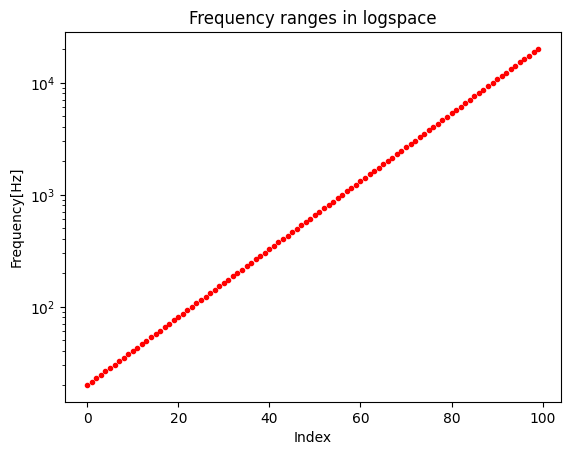

In [40]:
# Create a line plot
plt.plot(indices, frequencies, 'r.')

# Add labels and title
plt.xlabel('Index')
plt.yscale('log')
plt.ylabel('Frequency[Hz]')
plt.title('Frequency ranges in logspace')

# Show the plot
plt.show()

In [24]:
def calc_frequency(divider, samples_count):
  return fclk / (divider * samples_count)

def calc_divider(freq, samples_count):
  return fclk / (freq * samples_count)

def calc_delay(divider):
  return 1e6 / (fclk / divider)

datas = {}
samples_counts = [64, 128, 256, 512, 1024, 2048]
for samples_count in samples_counts:
  data = {
      'f0[Hz]': [round(frequency, 3) for frequency in frequencies],
  }

  dividers = [round(calc_divider(frequency, samples_count)) for frequency in frequencies] # dividers are integers
  nearest_frequencies = [calc_frequency(divider, samples_count) for divider in dividers]
  nearest_frequencies_rounded = [round(nearest_frequency, 3) for nearest_frequency in nearest_frequencies]
  frequency_errors = [round(frequency - nearest_frequency, 3) for frequency, nearest_frequency in zip(frequencies, nearest_frequencies)]
  frequency_errors_rel = [round(100.0 * abs(frequency - nearest_frequency) / frequency, 1) for frequency, nearest_frequency in zip(frequencies, nearest_frequencies)]
  delays = [round(calc_delay(divider), 1) for divider in dividers]

  data[f"f[Hz]_{samples_count}"] = nearest_frequencies_rounded
  data[f"err[Hz]_{samples_count}"] = frequency_errors
  data[f"err[%]_{samples_count}"] = frequency_errors_rel
  data[f"div_{samples_count}"] = dividers
  data[f"delay[us]_{samples_count}"] = delays

  datas[samples_count] = data

pd.DataFrame(datas[1024])


,f0[Hz],f[Hz]_1024,err[Hz]_1024,err[%]_1024,div_1024,delay[us]_1024
0,20.000,20.000,0.000,0.0,3125,48.8
1,21.445,21.448,-0.003,0.0,2914,45.5
2,22.995,22.995,0.000,0.0,2718,42.5
3,24.657,24.655,0.002,0.0,2535,39.6
4,26.439,26.438,0.001,0.0,2364,36.9
...,...,...,...,...,...,...
95,15129.267,15625.000,-495.733,3.3,4,0.1
96,16222.617,15625.000,597.617,3.7,4,0.1
97,17394.980,15625.000,1769.980,10.2,4,0.1
98,18652.067,20833.333,-2181.266,11.7,3,0.0


Find parameters as list of: samples count, divider, relative error, delay. The smaller delay the better only if error is lower than preset 0.3%.
Error is not the most important here.

In [25]:
parameters = []

# initial values
data_64 = datas[64];
for idx, frequency in enumerate(frequencies):
  parameters.append((64, data_64["div_64"][idx], data_64["err[%]_64"][idx], data_64["delay[us]_64"][idx]))

# try to find better values
index = 0
for samples_count, data in datas.items():
  if(samples_count == 64):
    continue
  data_div = data[f"div_{samples_count}"]
  data_err_perc = list(data[f"err[%]_{samples_count}"])
  data_delay = list(data[f"delay[us]_{samples_count}"])

  for idx, (div, err_perc, delay) in enumerate(zip(data_div, data_err_perc, data_delay)):
    if(err_perc > 0.3):
      continue
    if(delay < abs(parameters[idx][3])):
      parameters[idx] = (samples_count, div, err_perc, delay)

  # show results in table
data_frame = {
    "samples_count": [samples_count for samples_count, div, err_perc, delay in parameters],
    "div": [div for samples_count, div, err_perc, delay in parameters],
    "err[%]": [err_perc for samples_count, div, err_perc, delay in parameters],
    "delay[us]": [delay for samples_count, div, err_perc, delay in parameters],
    "freq[Hz]": [round(calc_frequency(div, samples_count), 3) for samples_count, div, err_perc, delay in parameters],
}
pd.DataFrame(data_frame)

,samples_count,div,err[%],delay[us],freq[Hz]
0,2048,1562,0.0,24.4,20.006
1,2048,1457,0.0,22.8,21.448
2,2048,1359,0.0,21.2,22.995
3,2048,1267,0.0,19.8,24.665
4,2048,1182,0.0,18.5,26.438
...,...,...,...,...,...
95,128,33,0.1,0.5,15151.515
96,64,62,0.6,1.0,16129.032
97,64,57,0.9,0.9,17543.860
98,64,54,0.7,0.8,18518.519


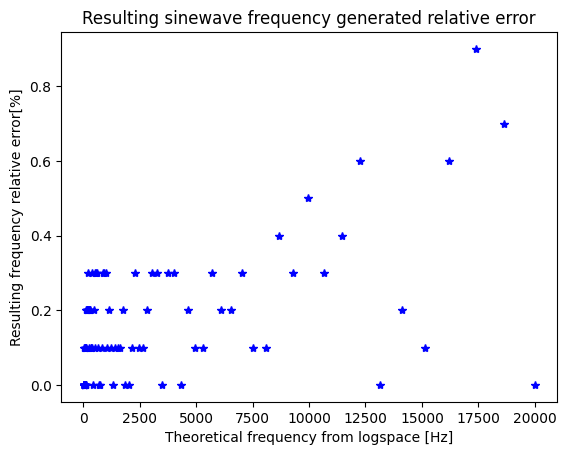

In [26]:
# Create a line plot
plt.plot(frequencies, [err_perc for samples_count, div, err_perc, delay in parameters], 'b*')

# Add labels and title
plt.xlabel('Theoretical frequency from logspace [Hz]')
plt.ylabel('Resulting frequency relative error[%]')
plt.title('Resulting sinewave frequency generated relative error')

# Show the plot
plt.show()

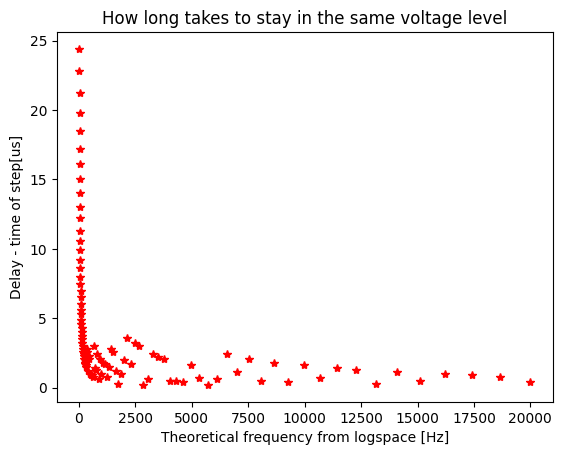

In [29]:
# Create a line plot
plt.plot(frequencies, [delay for samples_count, div, err_perc, delay in parameters], 'r*')

# Add labels and title
plt.xlabel('Theoretical frequency from logspace [Hz]')
plt.ylabel('Delay - time of step[us]')
plt.title('How long takes to stay in the same voltage level')

# Show the plot
plt.show()

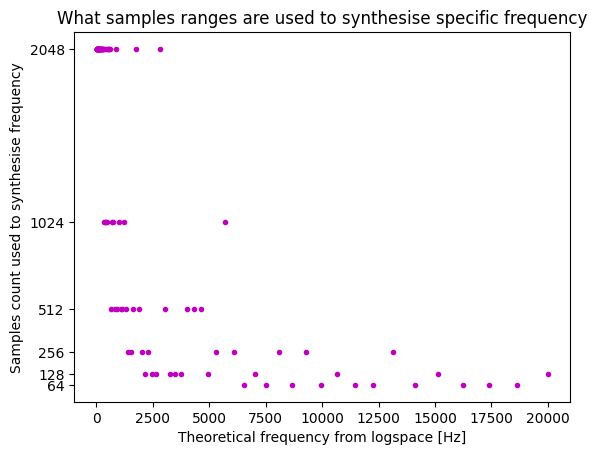

In [39]:
# Create a line plot
plt.plot(frequencies, [samples_count for samples_count, div, err_perc, delay in parameters], 'm.')

# Add labels and title
plt.xlabel('Theoretical frequency from logspace [Hz]')
plt.yticks(samples_counts)
plt.ylabel('Samples count used to synthesise frequency')
plt.title('What samples ranges are used to synthesise specific frequency')

# Show the plot
plt.show()

Min value 36, max value: 4060 of (0-4095)
Is total samples count valid: True


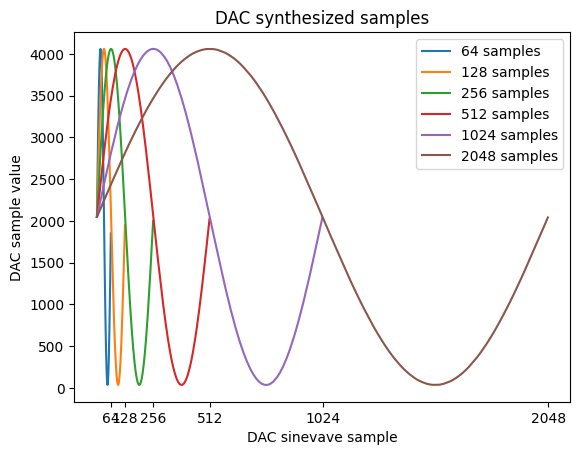

In [65]:
# generate data to be stored as C code

import math

dac_resolution_bits = 12
dac_max_value = 2**dac_resolution_bits - 1
sine_middle_value = 2048
sine_amplitude = 2012


samples_array = []
samples_map = {}
index = 0
for samples_count in samples_counts:
  dac_samples = []
  # generate sinewave
  for i in range(samples_count):
    dac_sample = round(sine_middle_value + sine_amplitude * math.sin(2 * math.pi * i / samples_count))
    dac_samples.append(dac_sample)
    samples_array.append(dac_sample)
  samples_map[samples_count] = (index, samples_count, dac_samples)
  index += samples_count

  #visualize
  plt.plot(list(range(samples_count)), dac_samples, label=f"{samples_count} samples")

print(f"Min value {sine_middle_value - sine_amplitude}, max value: {sine_middle_value + sine_amplitude} of (0-{dac_max_value})")
print(f"Is total samples count valid: {len(samples_array) == sum(samples_counts)}")

plt.xlabel('DAC sinevave sample')
plt.ylabel('DAC sample value')
plt.xticks(samples_counts)
plt.legend()
plt.title('DAC synthesized samples')

plt.show()


Generate C code with:
*   Sampled sinewaves
*   Parameters pointing to sinewaves samples ranges

Sinewaves can be gathered in one array.

In [75]:
# save file header .h
with open("dac_sines.h", "w") as f:
  f.write(f"#pragma once\n")
  f.write(f"#include <stdint.h>\n\n")
  f.write(f"#define DAC_SINES_COUNT {len(samples_counts)}\n")
  f.write(f"#define DAC_FREQ_STEPS {steps}\n")
  f.write(f"#define DAC_SAMPLES_VALUES_COUNT {len(samples_array)}\n")

  f.write('''
typedef struct sinewave_data_t {
	uint32_t start_idx;
	const uint16_t* mem_ptr;
	uint32_t samples_count;
	uint32_t divider;
  float frequency_hz;
} sinewave_data_t;

''')

  f.write(f"extern const uint16_t dac_samples_values[DAC_SAMPLES_VALUES_COUNT];\n")
  f.write(f"extern const sinewave_data_t dac_samples_data[DAC_FREQ_STEPS];\n")

# save file source .c
values_per_row = 8

with open("dac_sines.c", "w") as f:
  f.write(f"#include \"dac_sines.h\"\n")
  f.write(f"#include <math.h>\n\n")

  f.write("const uint16_t dac_samples_values[DAC_SAMPLES_VALUES_COUNT] = {\n")

  for idx, sample in enumerate(samples_array):
    f.write(f"{sample:5}, ")
    if idx % values_per_row == (values_per_row - 1):
      f.write("\n")

  f.write("};\n\n")

  f.write("/* " + f"{'Start':6}, {'memptr':15}, {'Count':6}, {'Div':6}, {'Freq[Hz]':10} " + " */\n")
  f.write("const sinewave_data_t dac_samples_data[DAC_FREQ_STEPS] = {\n")
  for samples_count, div, _, _ in parameters:
    f.write("	{" + f"{samples_map[samples_count][0]:6}, {'dac_samples_values + ' + f'{samples_map[samples_count][0]:6}'}, {samples_count:6}, {div:6}, {float(round(calc_frequency(div,samples_count), 3)):10}F" + " },\n")
  f.write("};\n\n")